In [69]:
import os
import argparse
import numpy as np
import pandas as pd
import random
import warnings
import json
import yaml
from matplotlib import pyplot as plt
import seaborn as sns
import gc
#from kaggle.api.kaggle_api_extended import KaggleApi

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# 機械学習モデル
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost


In [70]:
parser = argparse.ArgumentParser()
parser.add_argument("--exper_name", default="single_model", help="実験名")
parser.add_argument("--dataset_dir", type=str, default="../input/home-credit-default-risk")
parser.add_argument("--results_dir", type=str, default="../output/kaggle/working")
parser.add_argument("--submit_file", type=str, default="submission.csv")
parser.add_argument("--competition_id", type=str, default="home-credit-default-risk")
parser.add_argument("--classifier", choices=["logistic", "knn", "svm", "random_forest", "bagging", "adaboost", "xgboost", "lightgbm", "catboost", "mlp"], default="catboost", help="分類器モデルの種類")
parser.add_argument('--save_checkpoints_dir', type=str, default="checkpoints", help="モデルの保存ディレクトリ")
parser.add_argument("--params_file", type=str, default="")
parser.add_argument('--load_checkpoints_paths', action='append', help="モデルの読み込みファイルのパス")
parser.add_argument("--train_mode", choices=["train", "test", "eval"], default="train", help="")
parser.add_argument('--gdbt_train_type', choices=['train', 'fit'], default="fit", help="GDBTの学習タイプ")
parser.add_argument("--n_splits", type=int, default=4, help="CV での学習用データセットの分割数")
parser.add_argument("--seed", type=int, default=71)
parser.add_argument('--submit', action='store_true')
parser.add_argument('--eda', action='store_true')
parser.add_argument('--debug', action='store_true')
#args = parser.parse_args()
args = parser.parse_args(args=[])

# 実験名を自動的に変更
if( args.exper_name == "single_model" ):
    args.exper_name += "_" + args.classifier
    if( args.params_file != "" ):
        args.exper_name += "_" + args.params_file.split(".")[0]

for key, value in vars(args).items():
    print('%s: %s' % (str(key), str(value)))


exper_name: single_model_catboost
dataset_dir: ../input/home-credit-default-risk
results_dir: ../output/kaggle/working
submit_file: submission.csv
competition_id: home-credit-default-risk
classifier: catboost
save_checkpoints_dir: checkpoints
params_file: 
load_checkpoints_paths: None
train_mode: train
gdbt_train_type: fit
n_splits: 4
seed: 71
submit: False
eda: False
debug: False


# データセットの基本情報の確認

In [71]:
# データセットの読み込み
df_application_train = pd.read_csv( os.path.join(args.dataset_dir, "application_train.csv" ) )
df_application_test = pd.read_csv( os.path.join(args.dataset_dir, "application_test.csv" ) )

In [72]:
# EDA 対象のデータ設定
df_train = df_application_train
df_test = df_application_test

In [73]:
df_train.shape

(307511, 122)

In [74]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
for col in df_train.columns:
    print(col)

SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APART

## 目的変数の分布確認

In [76]:
# 目的変数名
target_name = 'TARGET'

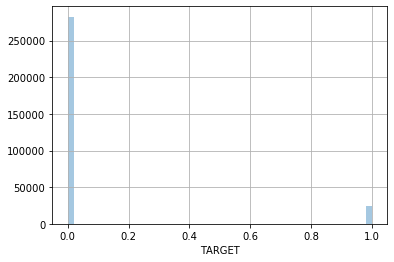

In [77]:
fig, axis = plt.subplots()
#df_train[target_name].hist()
sns.distplot( df_train[target_name], kde=False )
plt.grid()
plt.show()

- 0 : 期限内に返済
- 1 : 期限内に返済さえない（債務不履行）

## 説明変数の分布確認

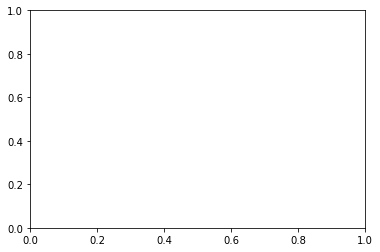

In [78]:
fig, axis = plt.subplots()
df_train.hist( bins=50, figsize=(160,120) )
plt.grid()
plt.show()

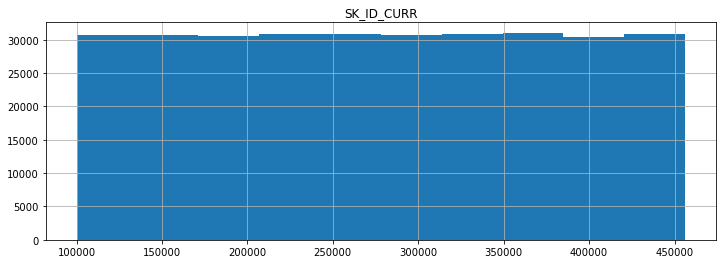

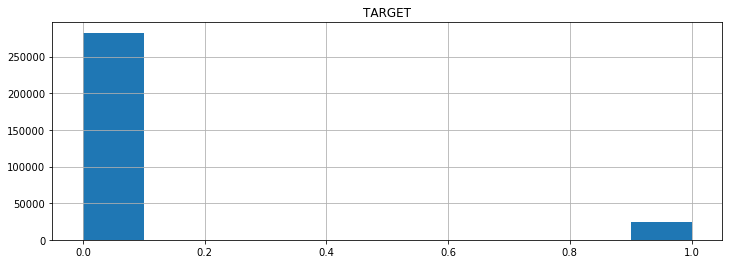

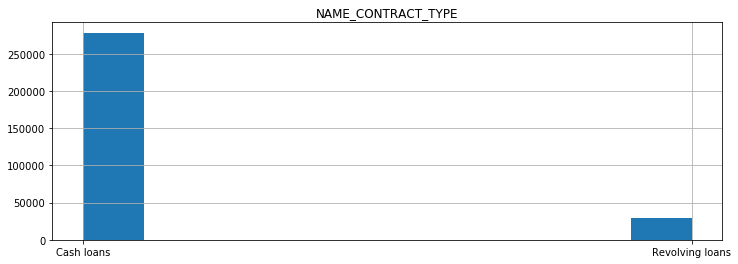

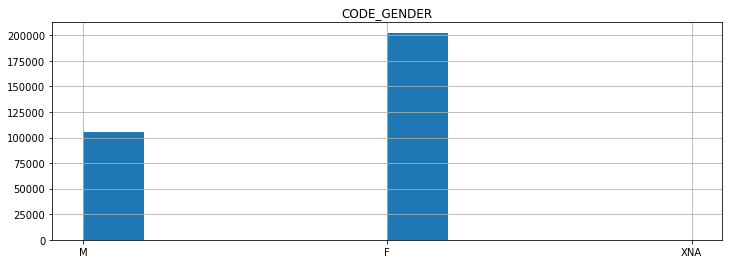

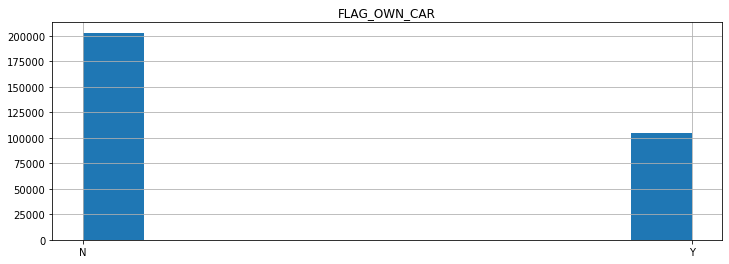

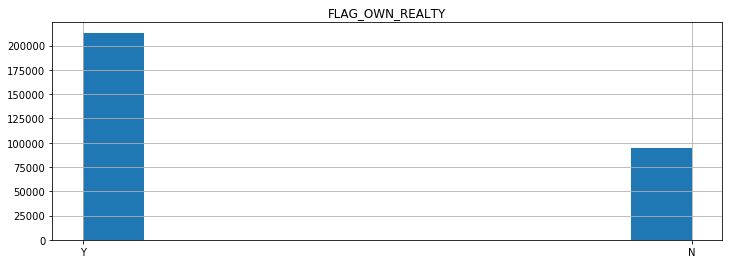

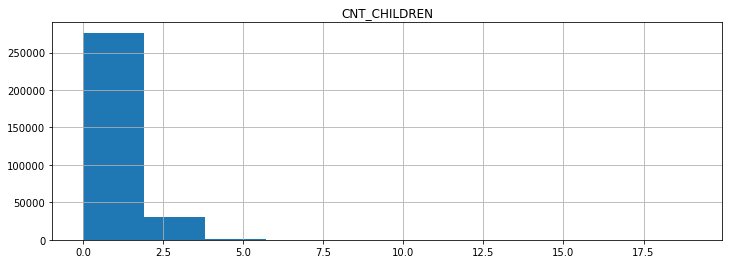

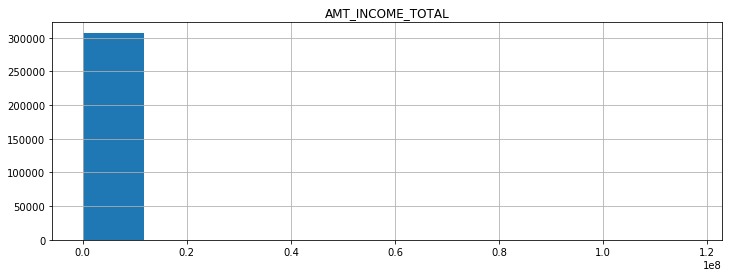

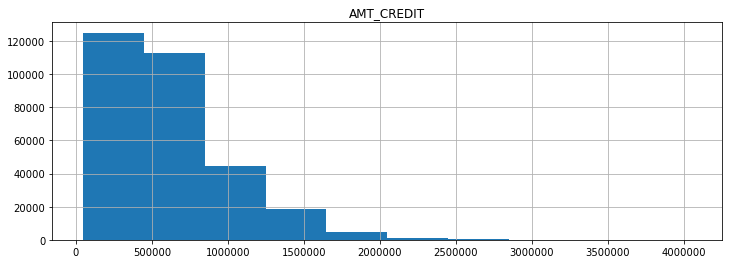

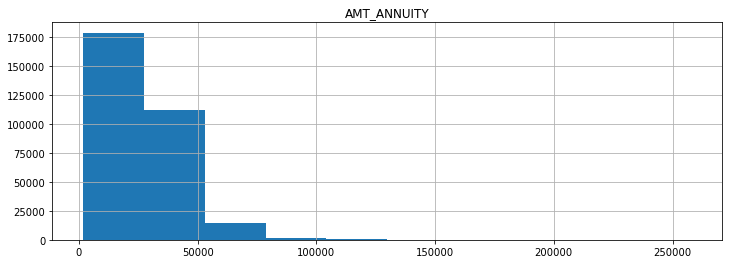

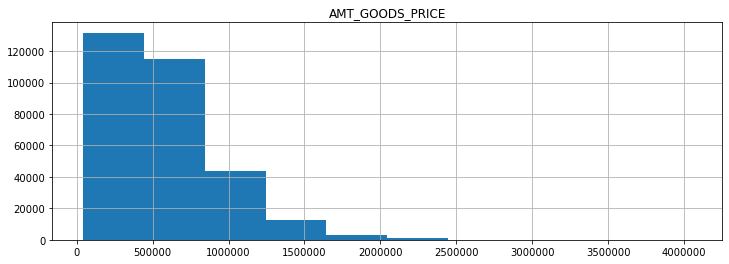

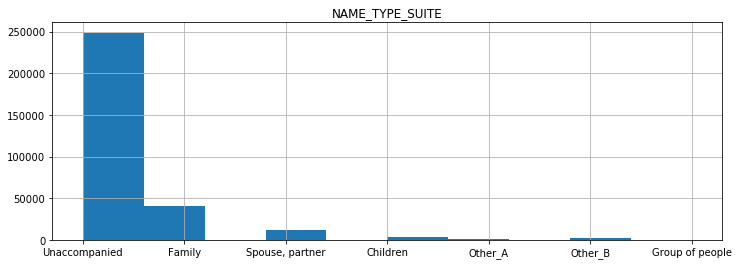

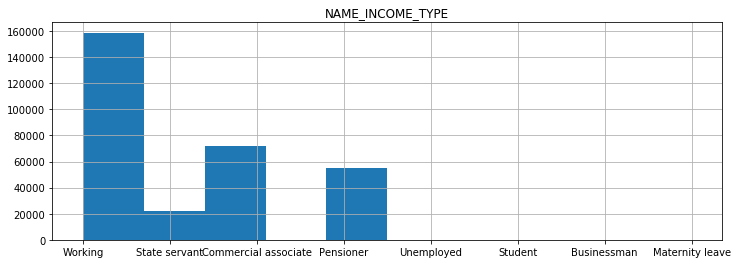

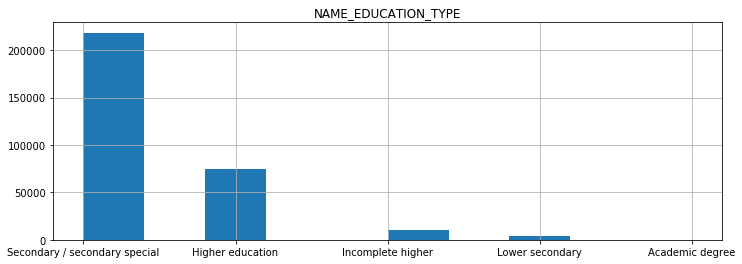

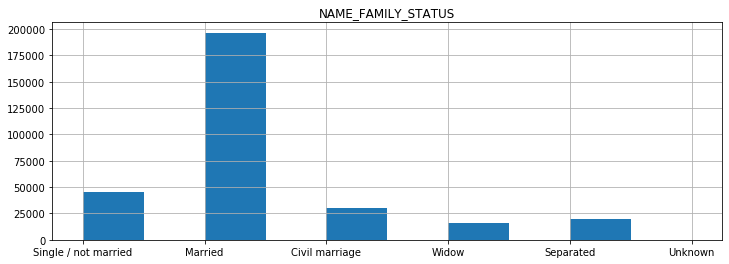

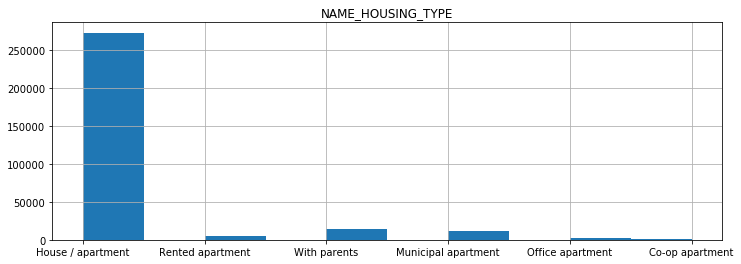

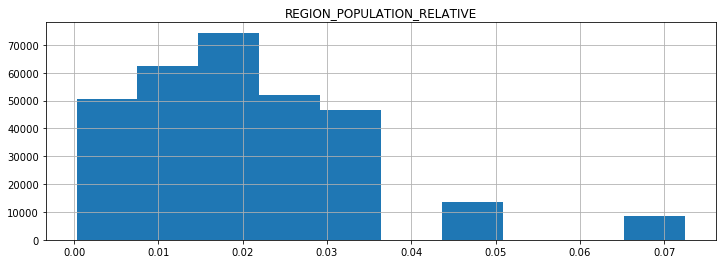

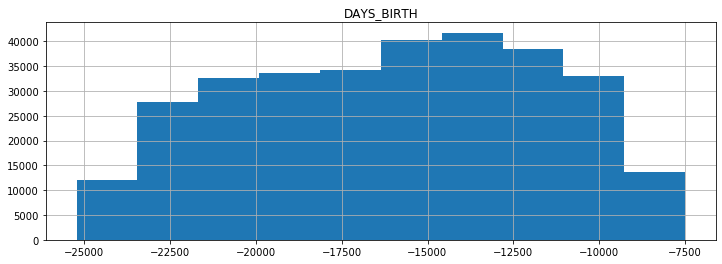

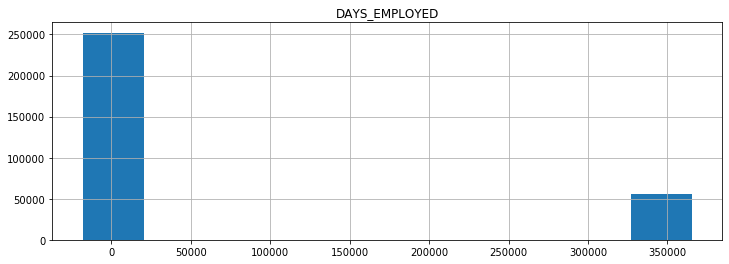

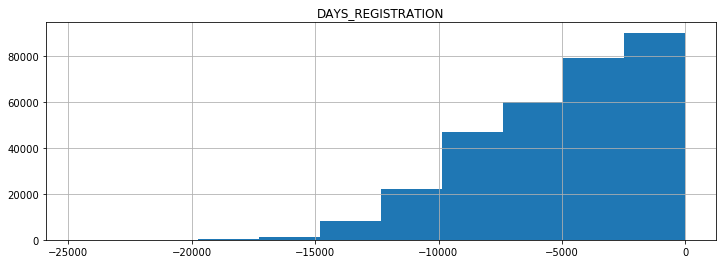

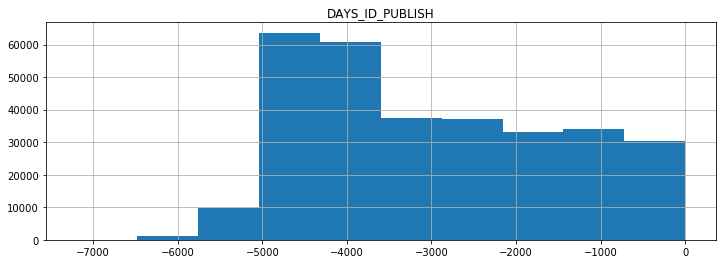

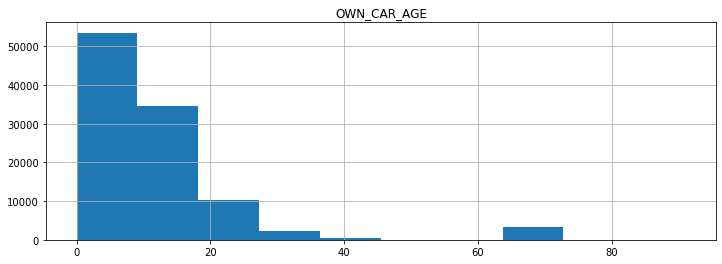

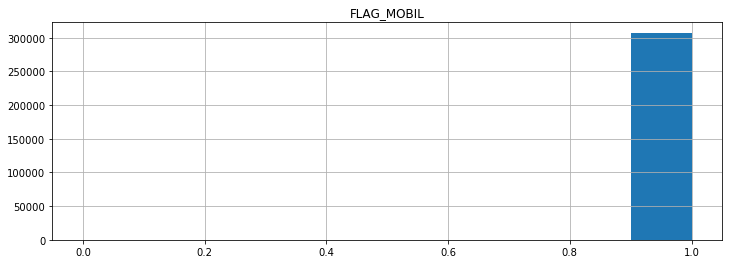

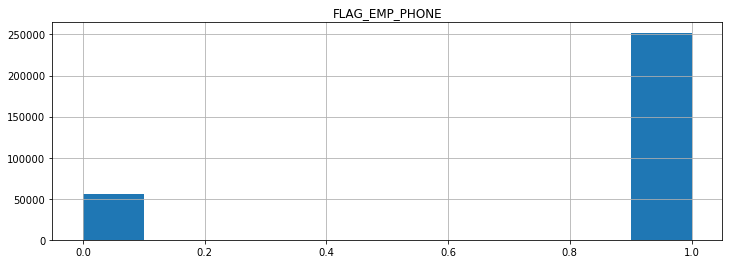

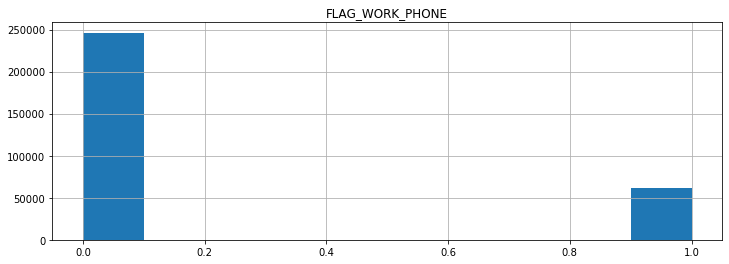

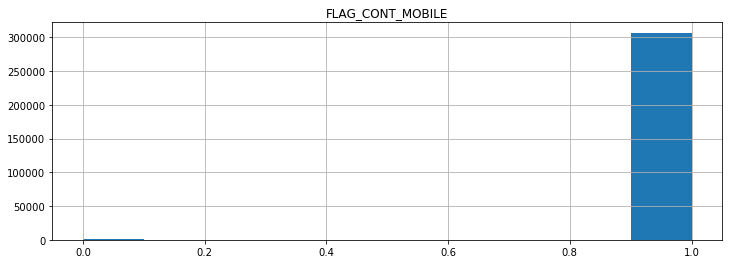

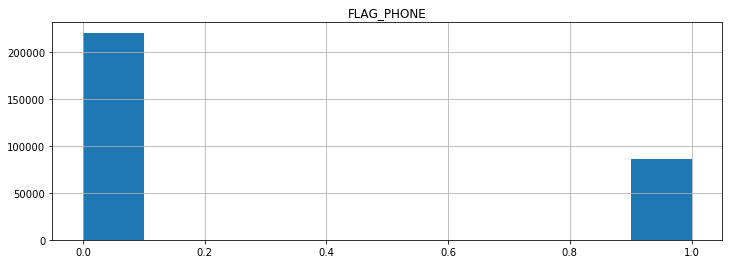

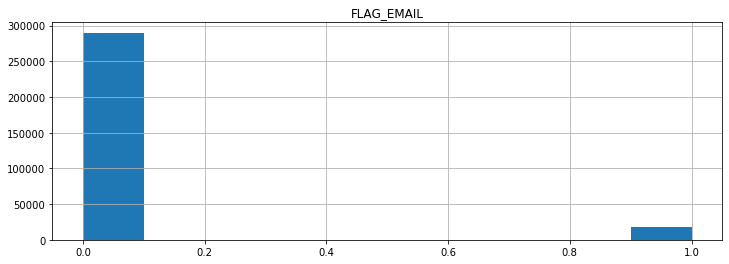

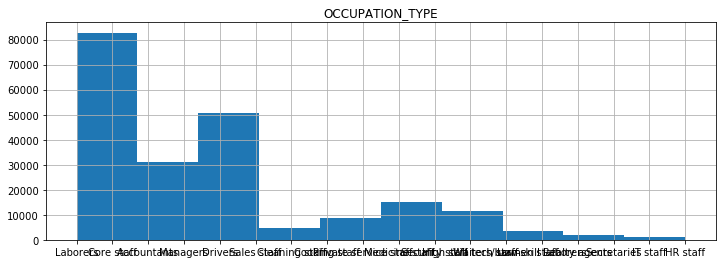

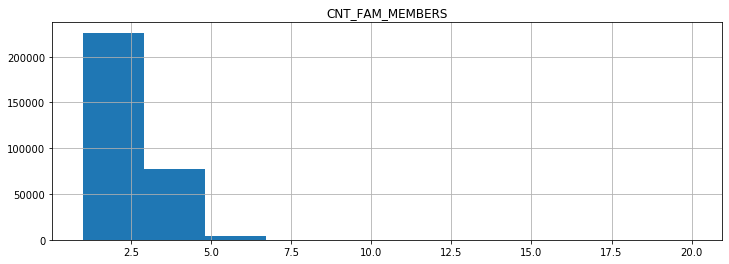

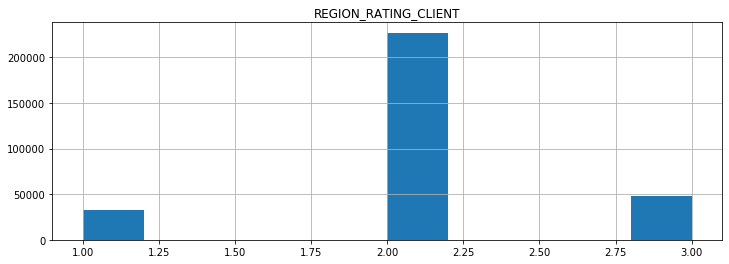

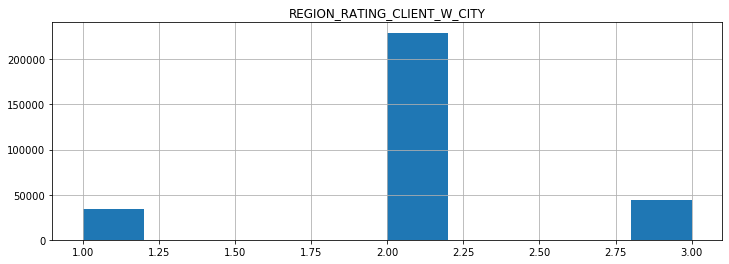

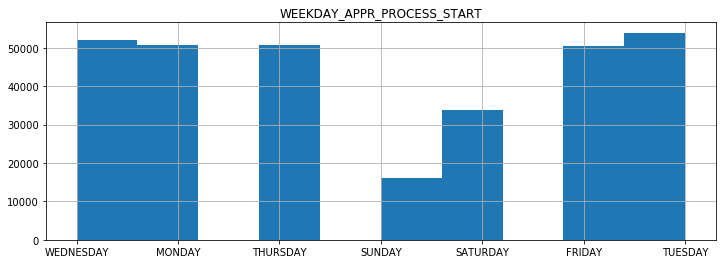

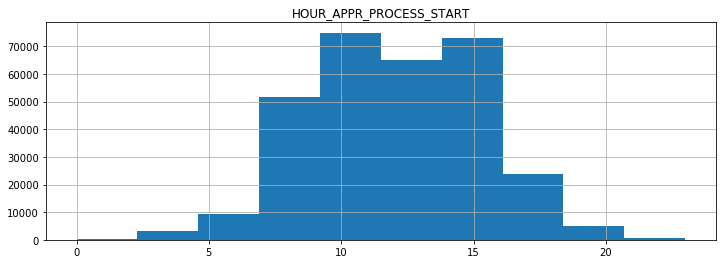

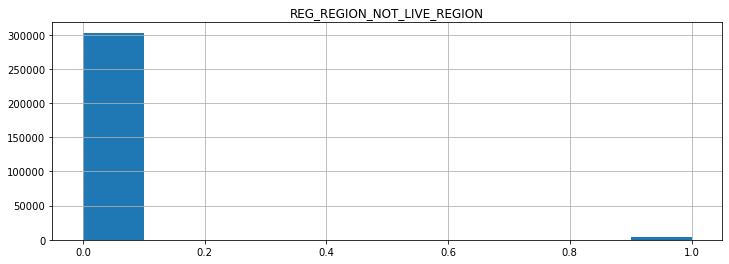

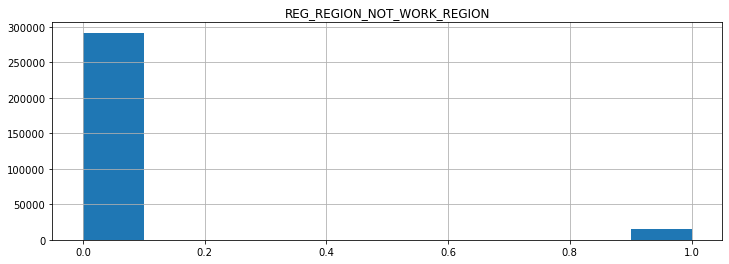

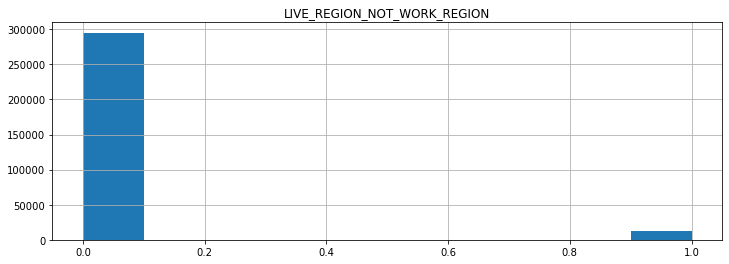

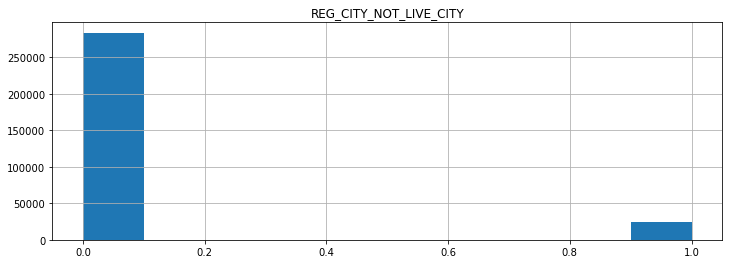

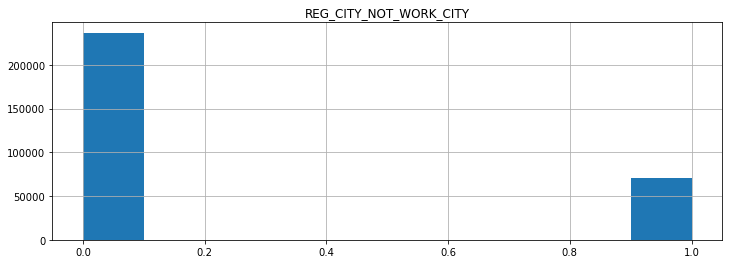

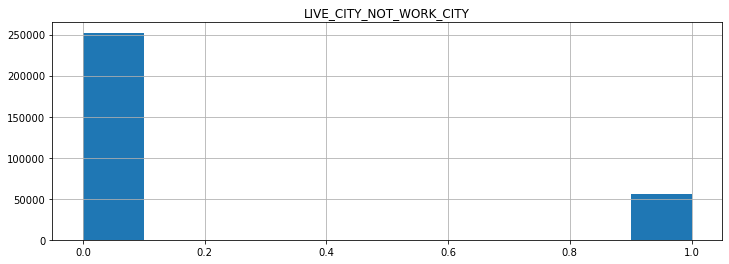

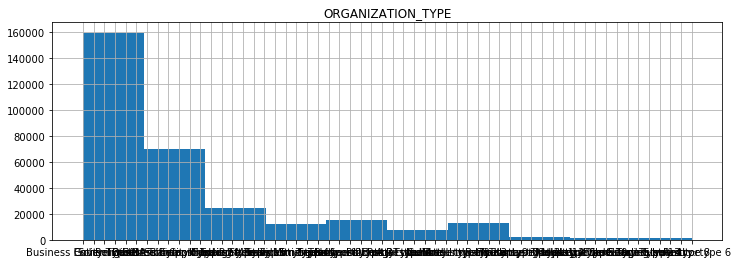

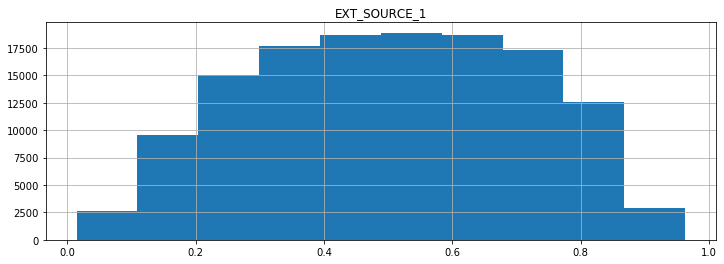

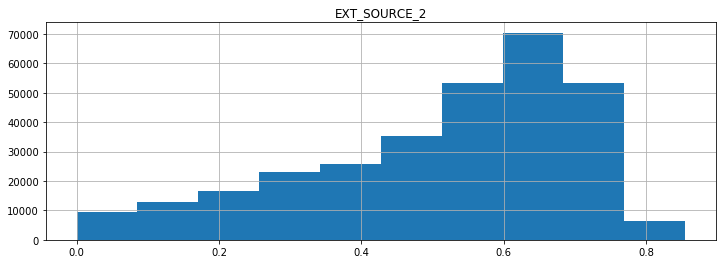

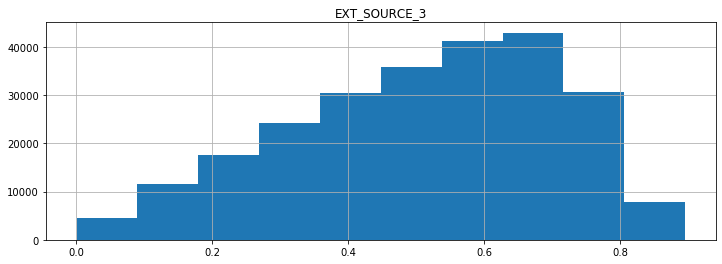

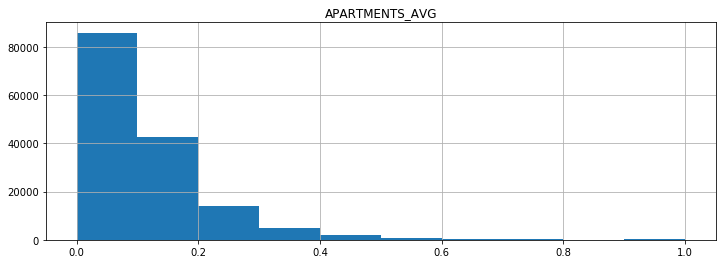

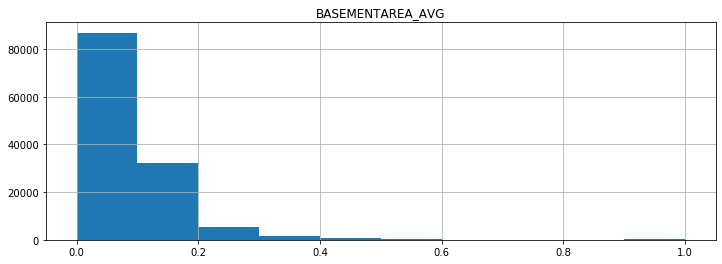

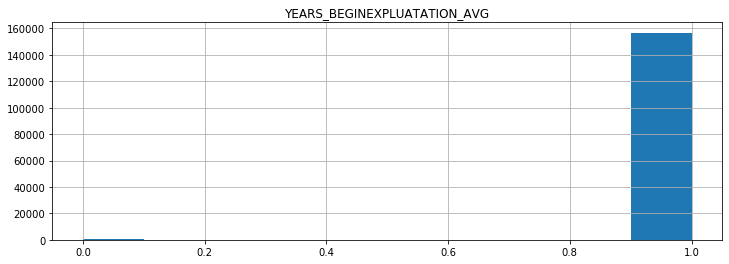

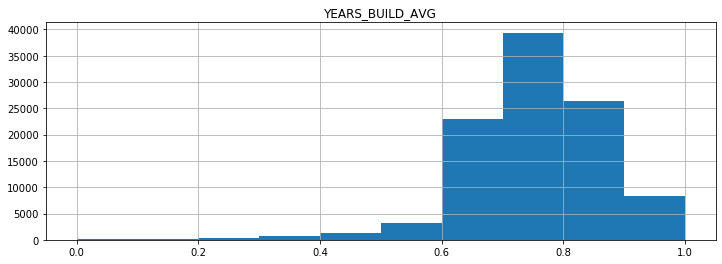

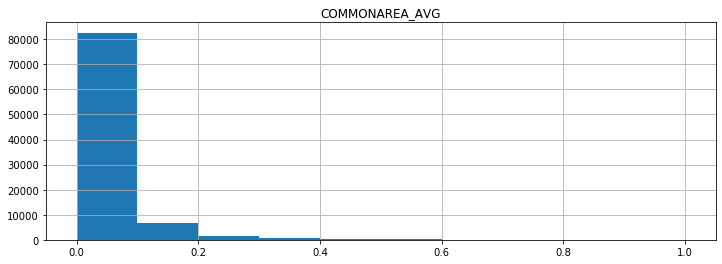

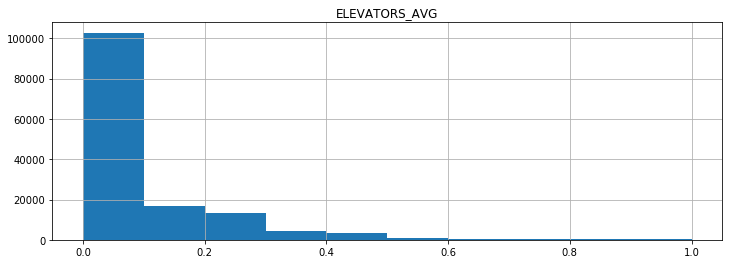

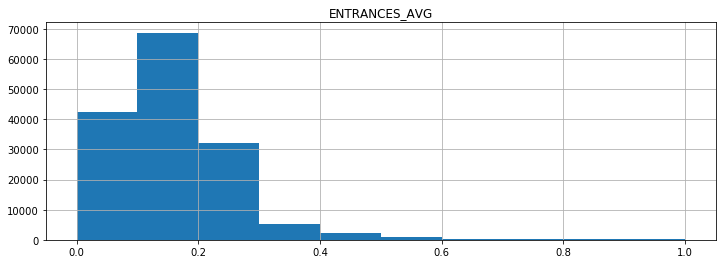

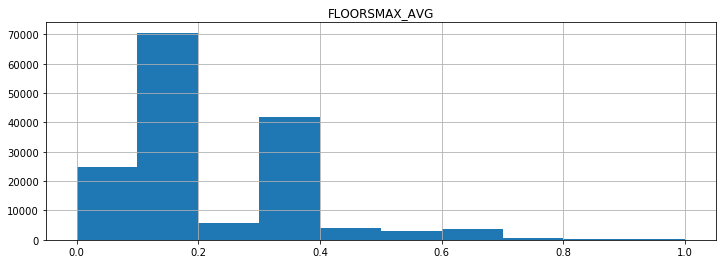

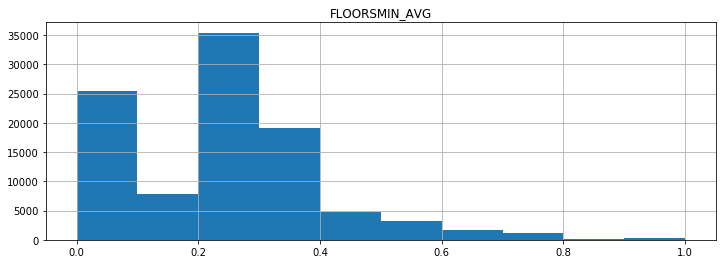

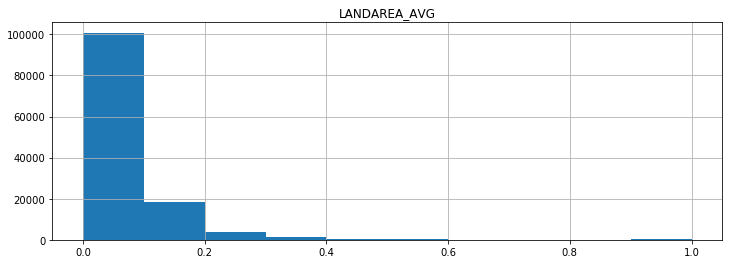

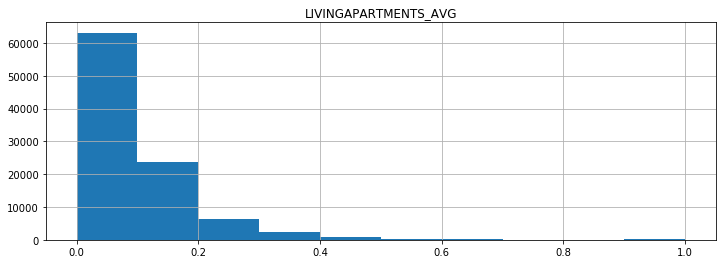

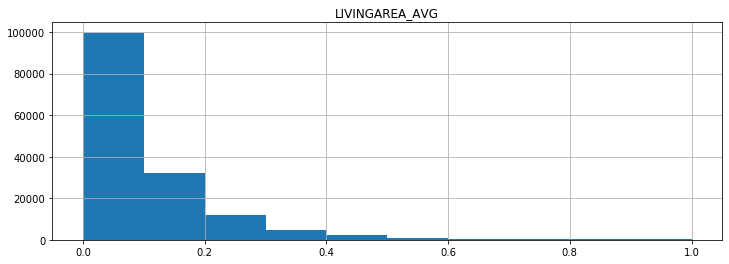

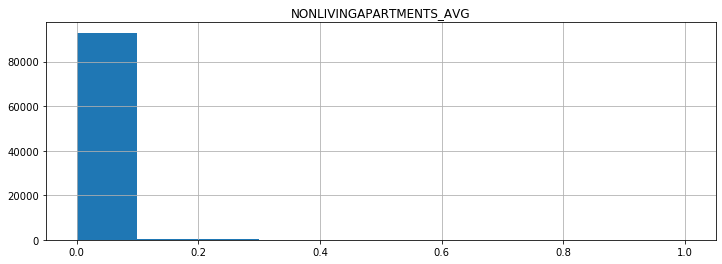

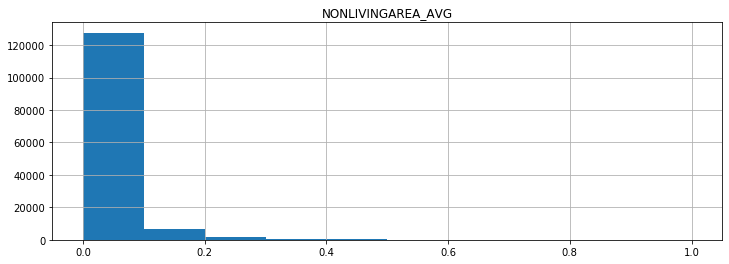

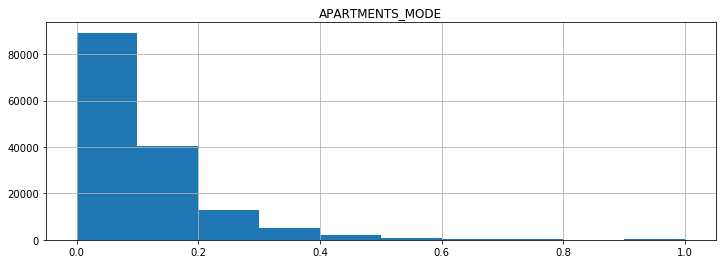

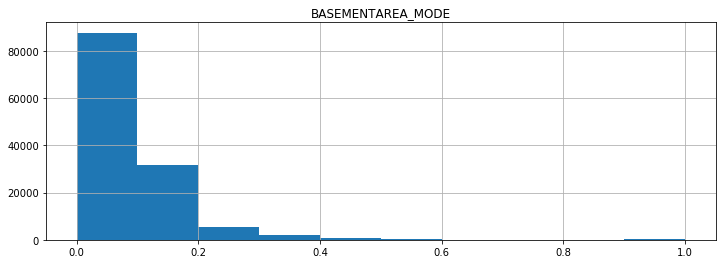

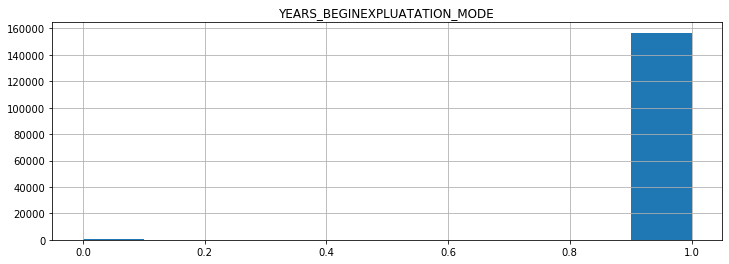

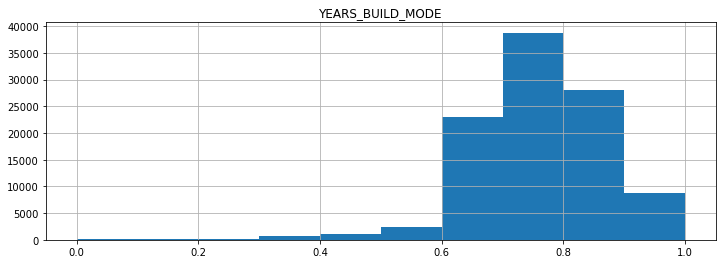

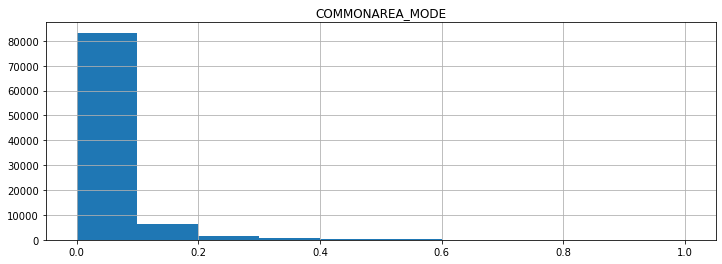

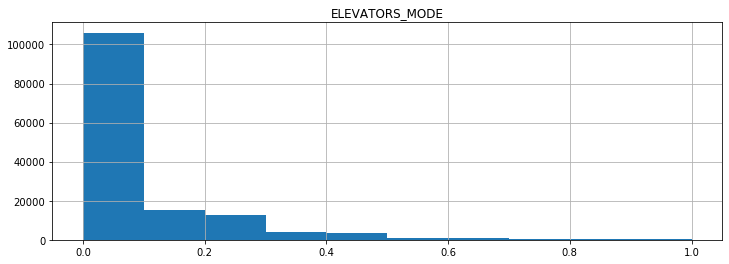

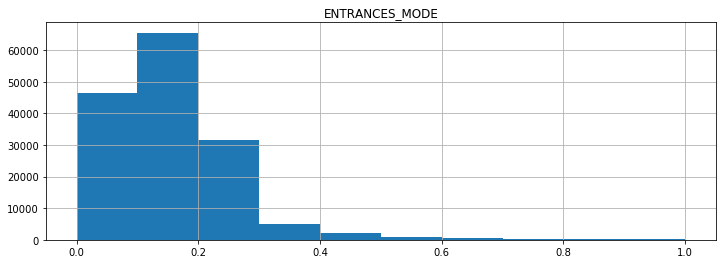

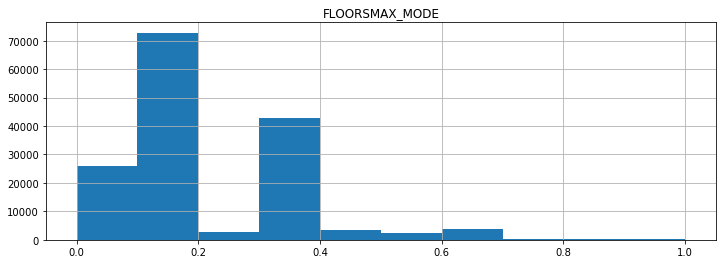

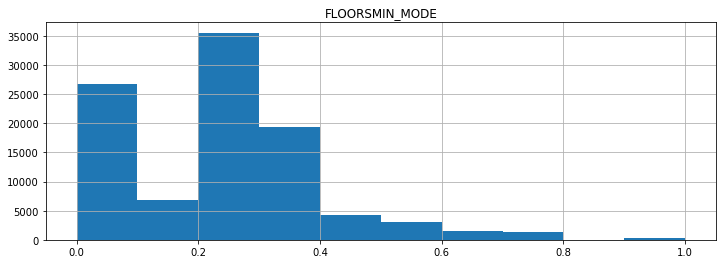

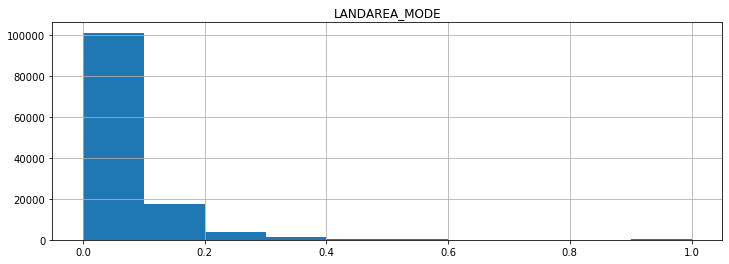

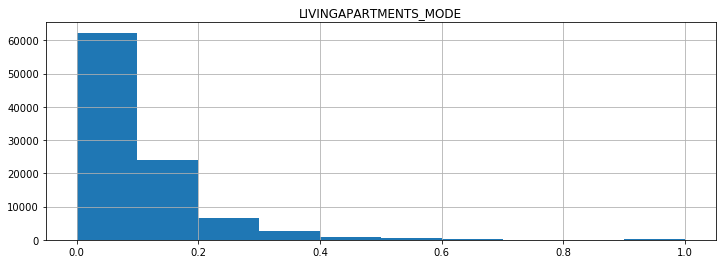

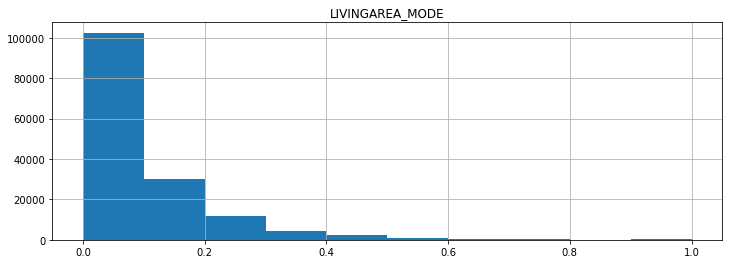

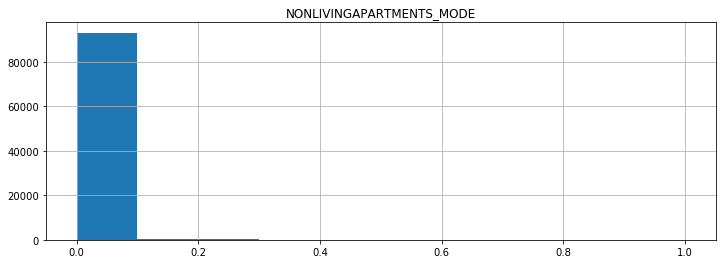

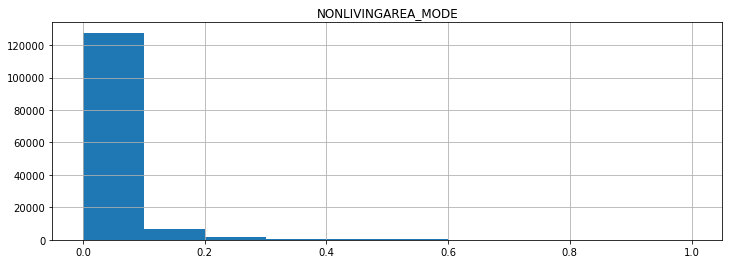

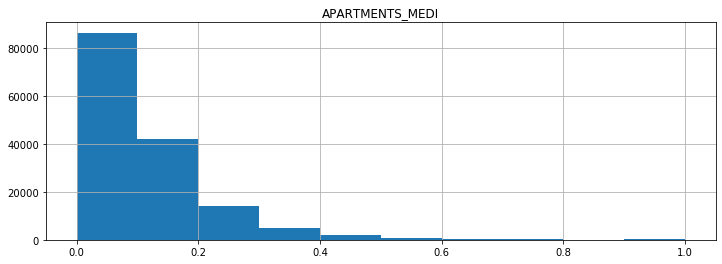

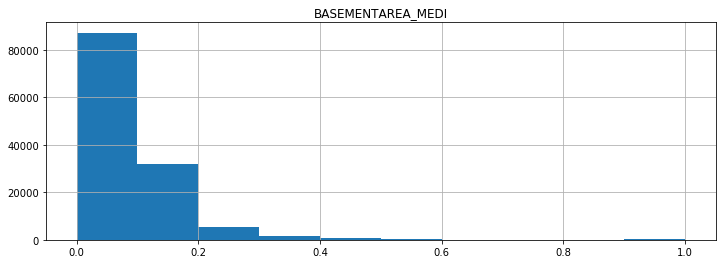

KeyboardInterrupt: 

In [79]:
for col in df_train.columns:
    df_train[col].hist( bins=10, figsize=(12,4), grid=True )
    plt.title(col)
    plt.show()

## 目的変数と説明変数の関係

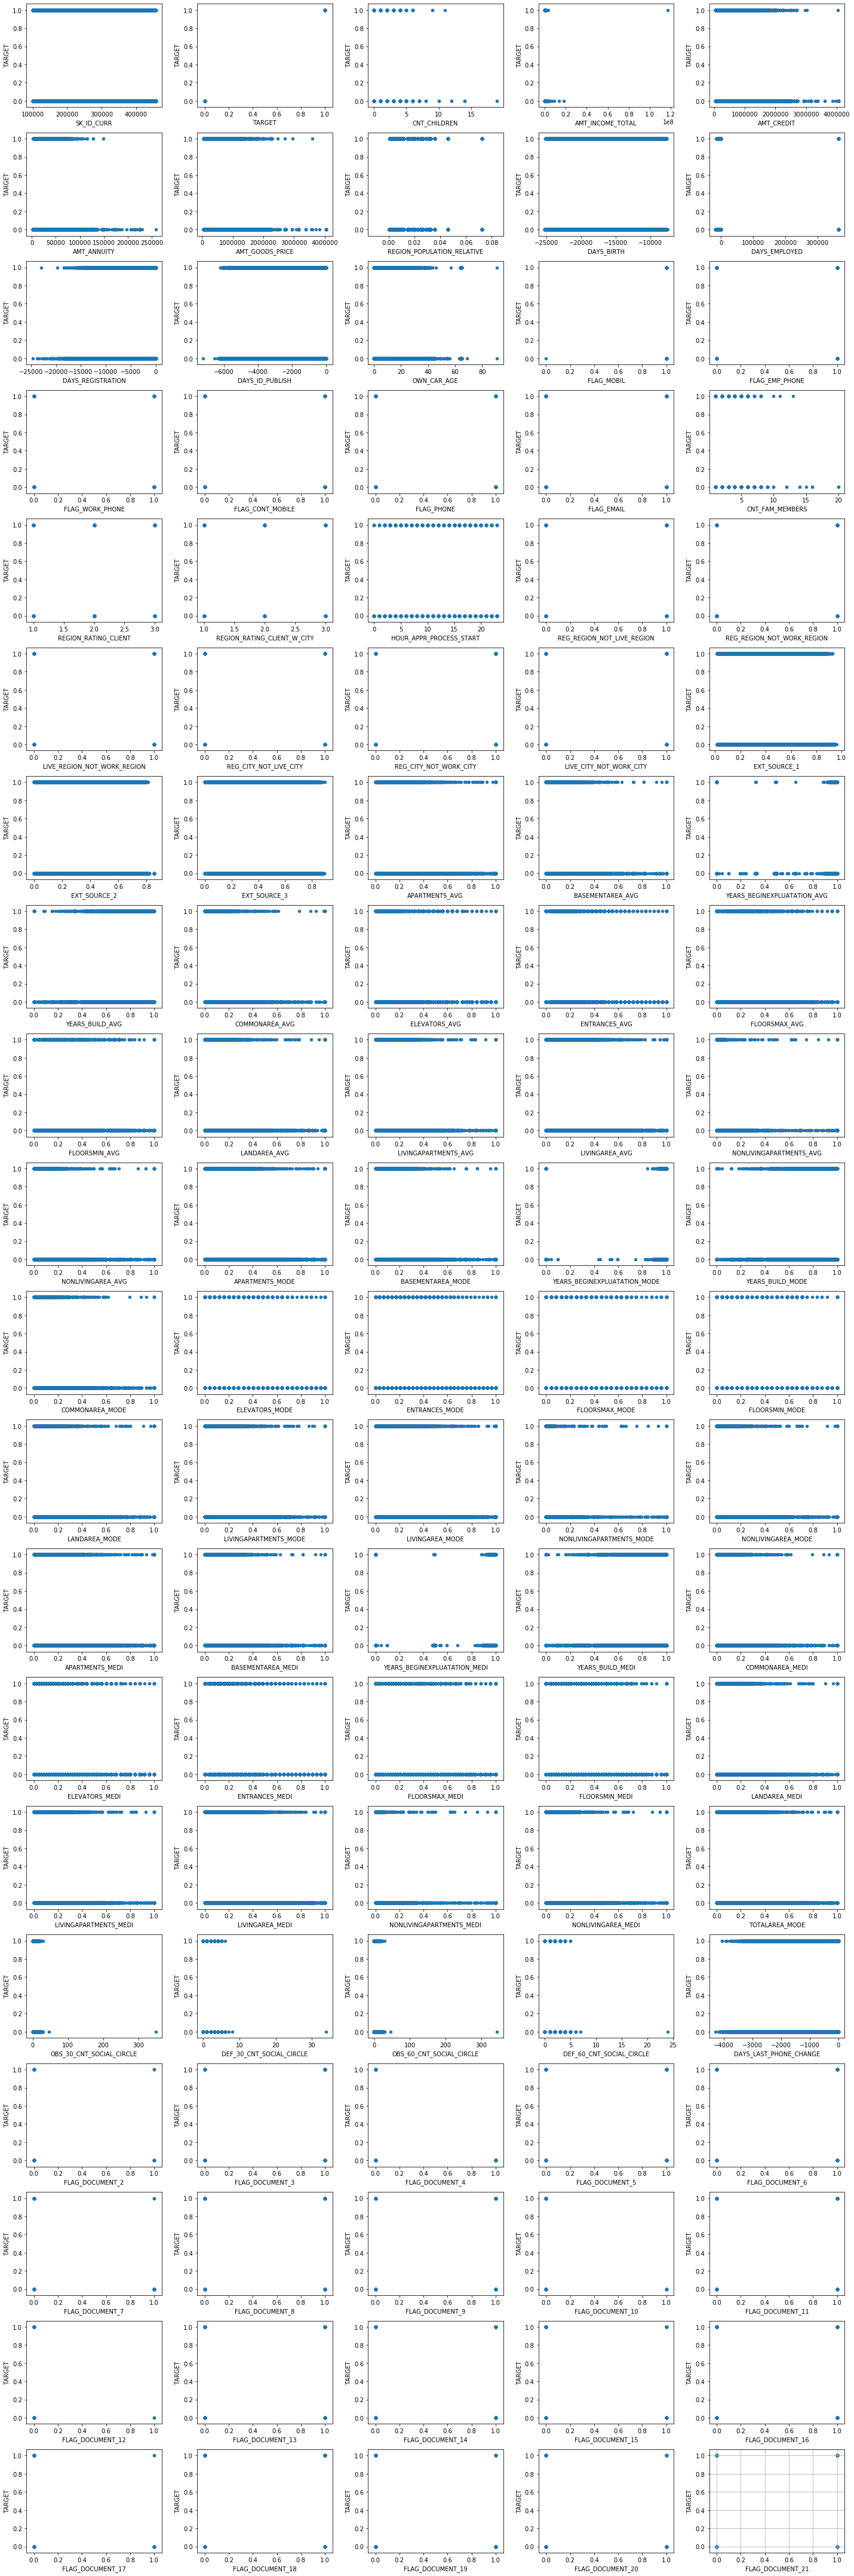

In [95]:
# 数値データ
feats = list( df_train.dtypes[ df_train.dtypes != "object" ].index )
n_rows, n_cols = 25, 5
fig, axis = plt.subplots(n_rows, n_cols, figsize=(n_cols*4,n_rows*3) )
for r in range(0, n_rows):
    for c in range(0, n_cols):  
        i = r * n_cols + c
        if i < len(feats):
            df_data = pd.concat([df_train[target_name], df_train[feats[i]]], axis=1)
            df_data.plot.scatter( x=feats[i], y=target_name, ax = axis[r][c] )
            plt.grid()

plt.tight_layout()
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'set_grid'

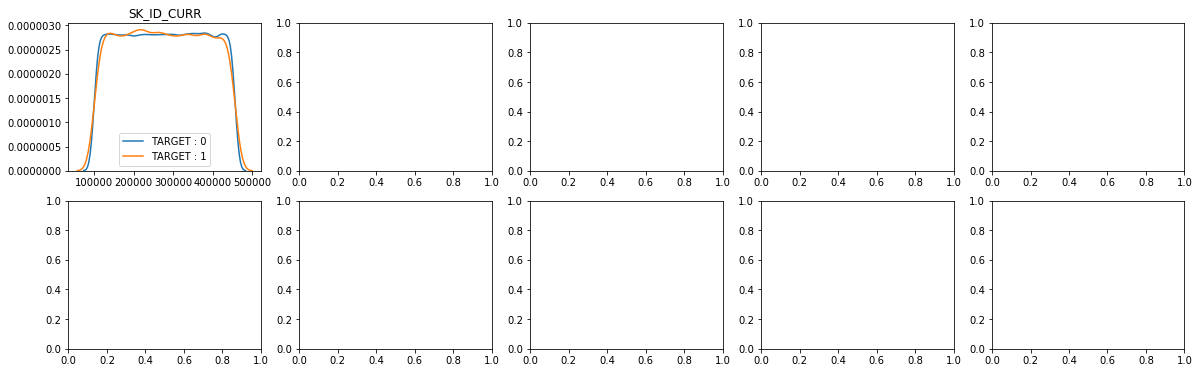

In [107]:
# 数値データ
feats = list( df_train.dtypes[ df_train.dtypes != "object" ].index )
n_rows, n_cols = 2, 5
fig, axis = plt.subplots(n_rows, n_cols, figsize=(n_cols*4,n_rows*3) )
for r in range(0, n_rows):
    for c in range(0, n_cols):  
        i = r * n_cols + c
        if i < len(feats):
            sns.kdeplot(df_train.loc[df_train[target_name] == 0, feats[i]], label = '{} : 0'.format(target_name), ax = axis[r][c] )
            sns.kdeplot(df_train.loc[df_train[target_name] == 1, feats[i]], label = '{} : 1'.format(target_name), ax = axis[r][c] )
            axis[r][c].set_title(feats[i])
            axis[r][c].grid()
            
plt.tight_layout()
plt.show()

#plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
#sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
#sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
#plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');
#plt.grid()

## 値が単一値のものがないか確認（単一値の特徴量はクレンジング対象）

In [ ]:
for col in df_train.columns:    
    print( "{} : {}".format(col,df_train[col].nunique(dropna=False)) )

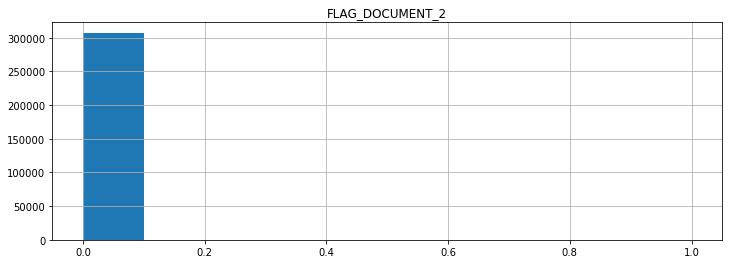

In [80]:
df_train["FLAG_DOCUMENT_2"].hist( bins=10, figsize=(12,4), grid=True )
plt.title("FLAG_DOCUMENT_2")
plt.show()

In [81]:
df_train["FLAG_DOCUMENT_2"].value_counts()

0    307498
1        13
Name: FLAG_DOCUMENT_2, dtype: int64

## 異常値データ確認

In [ ]:
for col in df_train.columns:  
    print( df_train[col].value_counts() )

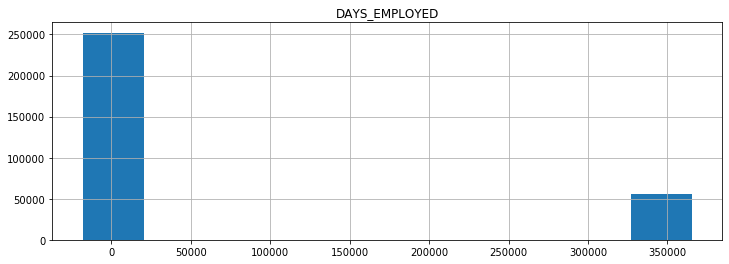

In [82]:
df_train["DAYS_EMPLOYED"].hist( bins=10, figsize=(12,4), grid=True )
plt.title("DAYS_EMPLOYED")
plt.show()

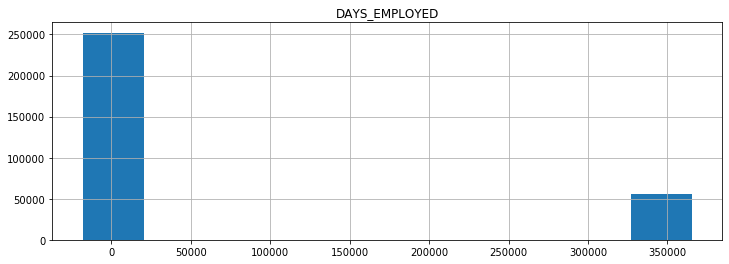

In [83]:
df_train["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
df_train["DAYS_EMPLOYED"].hist( bins=10, figsize=(12,4), grid=True )
plt.title("DAYS_EMPLOYED")
plt.show()

## 時系列データ確認

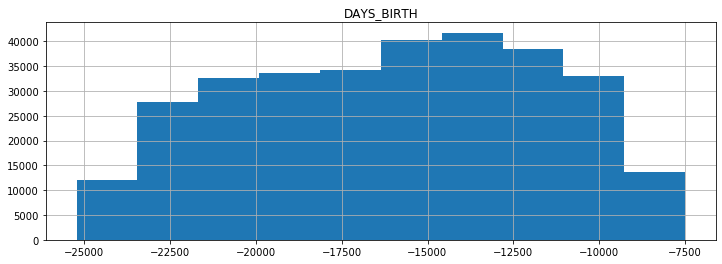

In [84]:
df_train["DAYS_BIRTH"].hist( bins=10, figsize=(12,4), grid=True )
plt.title("DAYS_BIRTH")
plt.show()

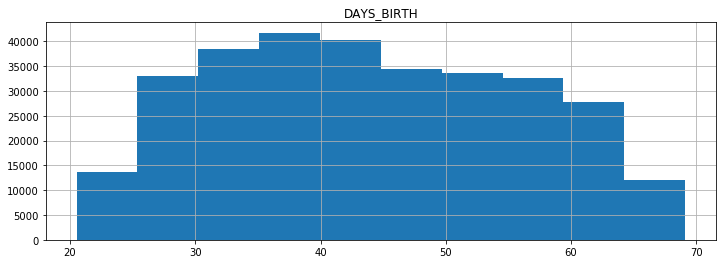

In [89]:
(df_train["DAYS_BIRTH"]/-365).hist( bins=10, figsize=(12,4), grid=True )
plt.title("DAYS_BIRTH")
plt.show()

In [94]:
df_train_age = df_train[['TARGET', 'DAYS_BIRTH']]
df_train_age['DAYS_BIRTH'] = df_train_age['DAYS_BIRTH'] / -1
df_train_age['YEARS_BIRTH'] = df_train_age['DAYS_BIRTH'] / 365
df_train_age['YEARS_BINNED'] = pd.cut(df_train_age['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

df_train_age.head(10)

#df_train_age["YEARS_BIRTH"].hist( bins=10, figsize=(12,4), grid=True )
#plt.title("YEARS_BIRTH")
#plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461.0,25.920548,"(25.0, 30.0]"
1,0,16765.0,45.931507,"(45.0, 50.0]"
2,0,19046.0,52.180822,"(50.0, 55.0]"
3,0,19005.0,52.068493,"(50.0, 55.0]"
4,0,19932.0,54.608219,"(50.0, 55.0]"
5,0,16941.0,46.413699,"(45.0, 50.0]"
6,0,13778.0,37.747945,"(35.0, 40.0]"
7,0,18850.0,51.643836,"(50.0, 55.0]"
8,0,20099.0,55.065753,"(55.0, 60.0]"
9,0,14469.0,39.641096,"(35.0, 40.0]"
